# <center> COVID-19 Spread Visualisation </center>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
from ipywidgets import interactive

%matplotlib inline

In [3]:
def read_data(name):
    
    result = {"cumulative_cities":[], "daily_cities":[], "total_infected":[]}
    
    for simulation in range(10):
        with open(f"{name}_{simulation}", 'rb') as f:
            data = pickle.load(f)

        data = pd.DataFrame(data).T
        cumulative_cities = np.cumsum(data.groupby('day')['infected'].count())
        daily_cities = data.groupby('day')['infected'].count()
        total_infected = data['infected'].apply(np.max).sum()

        result["cumulative_cities"].append(cumulative_cities)
        result["daily_cities"].append(daily_cities)
        result["total_infected"].append(total_infected)
        
    return result

def plot_with_std(data, label, color):
    average = data.mean()
    std = data.std()
    
    plt.plot(
        average, 
        label=label, 
        color=color, 
        linewidth=2
    )

    plt.fill_between(range(len(average)), average+std, average, alpha=0.1, color=color)
    plt.fill_between(range(len(average)), average-std, average, alpha=0.1, color=color)

In [5]:
realistic = read_data("../simulation_data/INFECTED_CITIES_realistic_3")
strict = read_data("../simulation_data/INFECTED_CITIES_strict_3")
mild = read_data("../simulation_data/INFECTED_CITIES_mild_3")

In [12]:
airport_df = pd.read_csv("../data/airport_df_preprocessed.csv", index_col=0)

In [6]:
realistic_label = 'Realistic quarantines after 30 days, 14 days to enforce (R0=4, R44=1)'
strict_label = 'Strict quarantines after 14 days, 7 days to enforce (R0=4, R21=1)'
mild_label = 'Mild quarantines after 60 days, 30 days to enforce (R0=4, R90=1)'

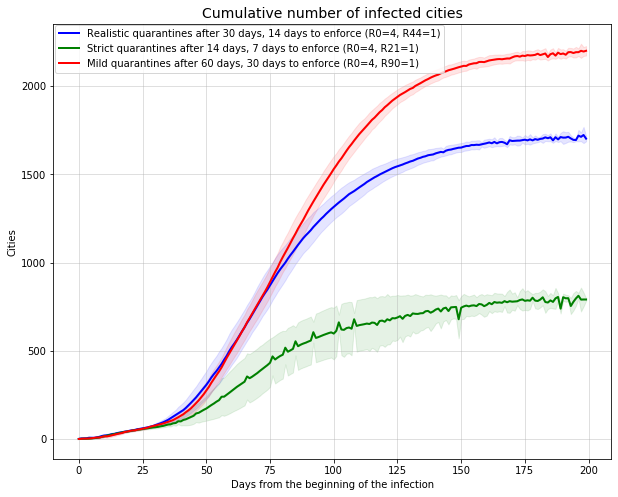

In [7]:
plt.figure(figsize=(10, 8))
plot_with_std(pd.DataFrame(realistic['cumulative_cities']), 
              label=realistic_label,
              color='blue'
             )

plot_with_std(pd.DataFrame(strict['cumulative_cities']), 
              label=strict_label,
              color='green'
             )

plot_with_std(pd.DataFrame(mild['cumulative_cities']), 
              label=mild_label,
              color='red'
             )

plt.title("Cumulative number of infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days from the beginning of the infection")
plt.grid(alpha=0.5)
plt.legend(loc=(0.002,0.888))
plt.show()

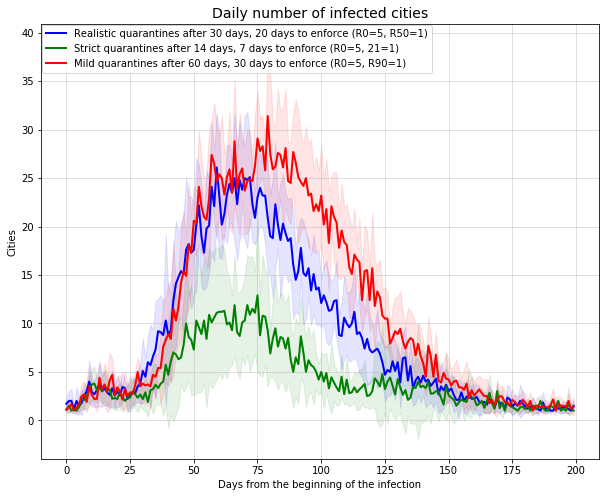

In [8]:
plt.figure(figsize=(10, 8))
plot_with_std(pd.DataFrame(realistic['daily_cities']), 
              label='Realistic quarantines after 30 days, 20 days to enforce (R0=5, R50=1)',
              color='blue'
             )

plot_with_std(pd.DataFrame(strict['daily_cities']), 
              label='Strict quarantines after 14 days, 7 days to enforce (R0=5, 21=1)',
              color='green'
             )

plot_with_std(pd.DataFrame(mild['daily_cities']), 
              label='Mild quarantines after 60 days, 30 days to enforce (R0=5, R90=1)',
              color='red'
             )

plt.title("Daily number of infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days from the beginning of the infection")
plt.grid(alpha=0.5)
plt.legend(loc=(0.002,0.888))
plt.show()

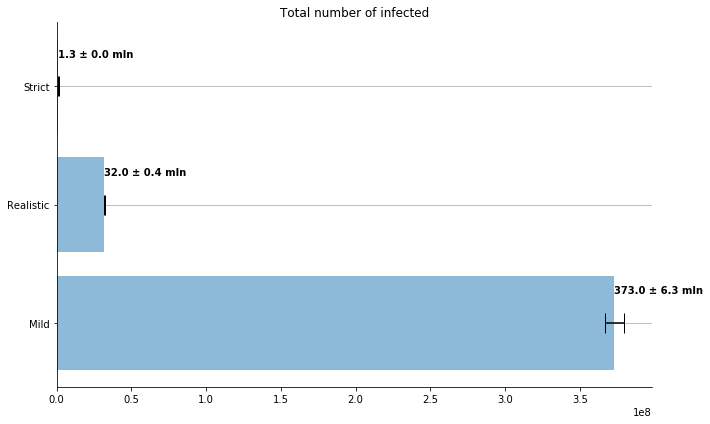

In [9]:
scenarios = ['Mild', 'Realistic', 'Strict']
x_pos = np.arange(len(scenarios))

averages = [
    np.mean(mild['total_infected']),
    np.mean(realistic['total_infected']),
    np.mean(strict['total_infected']),
]

stds = [
    np.std(mild['total_infected']),
    np.std(realistic['total_infected']),
    np.std(strict['total_infected']),
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x_pos, averages, align='center', xerr=stds, alpha=0.5, ecolor='black', capsize=10)
ax.set_yticks(x_pos)
ax.set_yticklabels(scenarios)
ax.set_title('Total number of infected')
ax.yaxis.grid(True)


for i, v in enumerate(averages):
    av = round(v/1000000, 1)
    std = round(stds[i]/1000000, 1)
    ax.text(v, i + .25, f"{av} ± {std} mln", color='black', fontweight='bold')

plt.tight_layout()
sns.despine()
plt.show()

In [13]:
np.array(averages)/airport_df.city_population.sum()

array([0.07697795, 0.00660835, 0.00026153])

In [179]:
def get_spread_data(file_name, airport_df=airport_df):
    with open(file_name, 'rb') as f:
        spread_data = pickle.load(f)
        
    spread_data = pd.DataFrame(spread_data).T
    spread_data = spread_data[['from', 'day']].reset_index()
    spread_data.columns = ['destination', 'source', 'day']
    spread_data = spread_data[['source', 'destination', 'day']]
    
    spread_data = pd.merge(
        spread_data, airport_df[['City', 'Lat', 'Long']], left_on='source', right_on='City')

    spread_data = pd.merge(
        spread_data, airport_df[['City', 'Lat', 'Long']], left_on='destination', right_on='City')

    spread_data.drop(['City_x', 'City_y'], axis=1, inplace=True)
    spread_data.rename(columns={
        'Lat_x':'lat_source', 
        'Long_x':'long_source',
        'Lat_y':'lat_dest',
        'Long_y':'long_dest'
    }, inplace=True)
    
    return spread_data

def get_graph(result_cities, airport_df=airport_df):
    graph = nx.from_pandas_edgelist(
        result_cities, 
        source = 'source', 
        target = 'destination',
        create_using = nx.DiGraph()
    )

    xycoords = {}

    for node in tqdm_notebook(list(graph.nodes), leave=False):
        xycoords[str(node)] = (
            airport_df.Long[airport_df.City ==node].values[0], 
            airport_df.Lat[airport_df.City == node].values[0]
        )
    return graph, xycoords

def visualise_spread(x, y):
    graph = nx.from_pandas_edgelist(
        result_cities[result_cities.day<=x], 
        source = 'source', 
        target = 'destination',
        create_using = nx.DiGraph()
    )
    plt.figure(figsize=(30, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cfeature.LAND, color='#3d3d3d')
    ax.add_feature(cfeature.OCEAN, color='#04031c')
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.outline_patch.set_visible(False)

    if y=='Nodes':
        nx.draw_networkx_nodes(graph,
                             pos=xycoords,
                             with_labels=False,
                             node_color='r',
                             node_size=5,
                             alpha=1)
    else:
        nx.draw_networkx(graph,
                     arrows=True,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     edge_color='orange',
                     style='dashed',
                     arrowstyle='->',
                     node_size=10,
                     alpha=0.5)

    plt.xlim(-180, 180)
    plt.ylim(-60, 80) 
    plt.show()

## Realistic scenario

![](../pictures/spread_realistic.png)

In [207]:
result_cities = get_spread_data("INFECTED_CITIES_realistic_2_0")
graph, xycoords = get_graph(result_cities)

interactive_plot = interactive(visualise_spread, 
                               x=list(range(0, 100)), 
                               y=['Nodes', 'Nodes and paths']
                              )
interactive_plot

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

## Optimistic (strict quarantines) scenario

![](../pictures/spread_optimistic.png)

In [208]:
result_cities = get_spread_data("INFECTED_CITIES_strict_2_0")
graph, xycoords = get_graph(result_cities)

interactive_plot = interactive(visualise_spread, 
                               x=list(range(0, 100)), 
                               y=['Nodes', 'Nodes and paths']
                              )
interactive_plot

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

## Pessimistic (mild quarantines) scenario

![](../pictures/spread_pessimistic.png)

In [209]:
result_cities = get_spread_data("INFECTED_CITIES_mild_2_0")
graph, xycoords = get_graph(result_cities)

interactive_plot = interactive(visualise_spread, 
                               x=list(range(0, 100)), 
                               y=['Nodes', 'Nodes and paths']
                              )
interactive_plot

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…